In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
df = pd.read_csv('Data.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


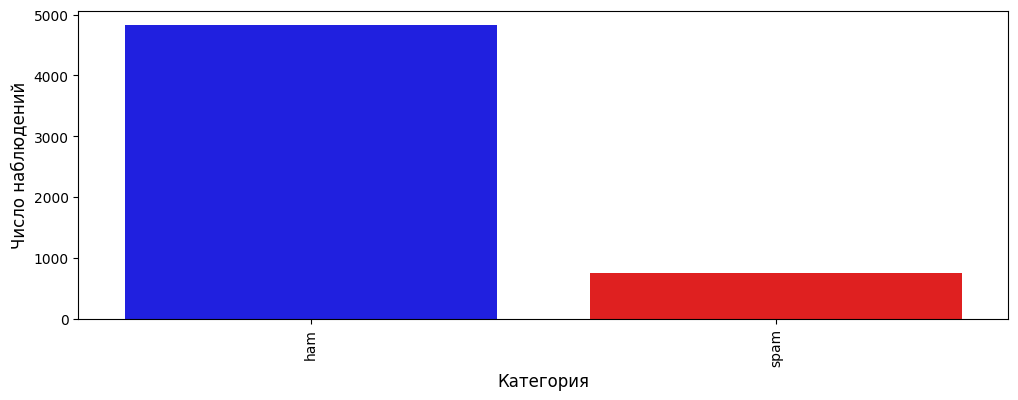

In [22]:
count_text = df['Category'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(count_text, alpha=1, palette=['blue', "red"])
plt.ylabel('Число наблюдений', fontsize=12)
plt.xlabel('Категория', fontsize=12)
plt.xticks(rotation=90)
plt.show()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #отключения предупреждения

In [4]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [6]:
df['Message'] = df['Message'].apply(preprocess_text)

In [7]:
category = pd.get_dummies(df['Category']).values
message = df['Message'].values

In [27]:
tokenizer = Tokenizer(num_words=2000, char_level=False, lower=True)
tokenizer.fit_on_texts(message)
sequences = tokenizer.texts_to_sequences(message)
data = pad_sequences(sequences, maxlen=500)

In [28]:
train_data, test_data, train_category, test_category = train_test_split(data, category, test_size=0.2, random_state=50) 

In [31]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, 32, input_length=500))
model.add(LSTM(16, dropout=0.4, recurrent_dropout=0.1))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
history = model.fit(train_data, train_category, validation_split=0.2, epochs=20, verbose=1)

Epoch 1/20
112/112 [==============================] - 26s 211ms/step - loss: 0.3471 - accuracy: 0.8763 - val_loss: 0.1511 - val_accuracy: 0.9451
Epoch 2/20
112/112 [==============================] - 24s 214ms/step - loss: 0.1023 - accuracy: 0.9764 - val_loss: 0.0776 - val_accuracy: 0.9865
Epoch 3/20
112/112 [==============================] - 24s 213ms/step - loss: 0.0534 - accuracy: 0.9910 - val_loss: 0.0583 - val_accuracy: 0.9899
Epoch 4/20
112/112 [==============================] - 24s 214ms/step - loss: 0.0353 - accuracy: 0.9938 - val_loss: 0.0507 - val_accuracy: 0.9888
Epoch 5/20
112/112 [==============================] - 24s 212ms/step - loss: 0.0245 - accuracy: 0.9955 - val_loss: 0.0492 - val_accuracy: 0.9922
Epoch 6/20
112/112 [==============================] - 23s 209ms/step - loss: 0.0169 - accuracy: 0.9969 - val_loss: 0.0504 - val_accuracy: 0.9888
Epoch 7/20
112/112 [==============================] - 23s 209ms/step - loss: 0.0127 - accuracy: 0.9978 - val_loss: 0.0495 - val_ac

In [37]:
loss, accuracy = model.evaluate(test_data, test_category, verbose=1)

print(f"Ошибка: {loss}")
print(f"Точность: {accuracy}")

35/35 [==============================] - 1s 23ms/step - loss: 0.0448 - accuracy: 0.9910
Ошибка: 0.04475581645965576
Точность: 0.9910314083099365


In [38]:
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis=-1)

results = pd.DataFrame({
    'True Label': np.argmax(test_category, axis=-1),
    'Predicted Label': predictions
})

total_records = len(results)
mismatch_records = len(results[results['True Label'] != results['Predicted Label']])
percent_loss = mismatch_records / total_records * 100

print(f'Число записей: {total_records}')
print(f'Число не совпадающих результатов: {mismatch_records}')
print(f'Процент ошибочных предсказаний: {percent_loss}')


35/35 [==============================] - 1s 23ms/step
Число записей: 1115
Число не совпадающих результатов: 10
Процент ошибочных предсказаний: 0.8968609865470852


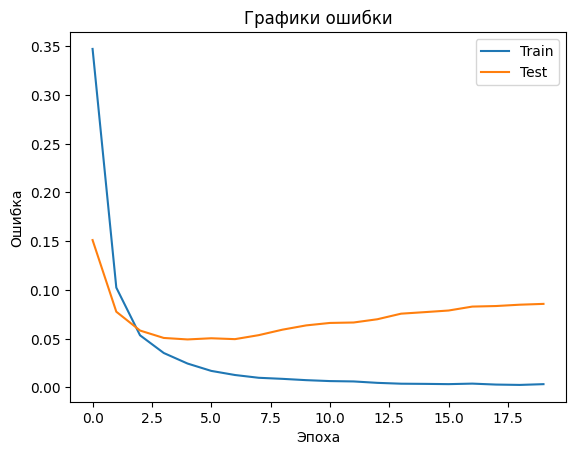

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Графики ошибки')
plt.ylabel('Ошибка')
plt.xlabel('Эпоха')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

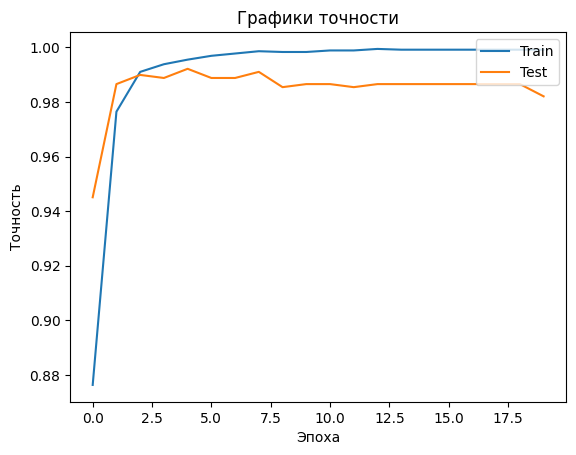

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Графики точности')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [44]:
model.save('model11l.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 32)           232736    
                                                                 
 lstm_4 (LSTM)               (None, 16)                3136      
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 235906 (921.51 KB)
Trainable params: 235906 (921.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Строки данных, которые можно поместить в датасет 'Test.csv' для проверки работы модели представлены в ячейке ниже

Данные записи были написаны исходя из стиля записей датасета, на котором обучалась сеть
ВАЖНО!!! Записи помещать по одной, имитирую работу фильтра электронной почты (на почту приходит не десяток писем, а одно и оно проверяется)

In [47]:
from keras.models import load_model

In [50]:
'''
1. spam,Get a free pass to our monthly lottery draw! Text LOTTO to 86121 to participate (standard text rate). T&C's apply 08452810077over18's
2. spam,"FreeMsg Hi there it's been a while! Fancy some fun? Reply with YES if you're in! XxX standard charges to send ?1.50 to receive"'s
3. spam,Win a chance to attend the Premier League final! Text PL to 81221 to get your entry question (standard text rate). T&C's apply 08452810076over18's
4. ham,"Head to the marina bay, amazing.. Only at orchard n wonderful world la e food court... Cinema there got more wat"
5. ham,Alright mate... Just pulling your leg
5. ham,"Go till the end of east coast park, wild.. Only in little india n fantastic world la e hawker centre... Theatre there got more wat.."
'''

model = load_model('model11l.h5')

df = pd.read_csv('Test.csv')

category_df = pd.get_dummies(df['Category'])
category = category_df.values
message = df['Message'].apply(preprocess_text).values

tokenizer = Tokenizer(num_words=2000, char_level=False, lower=True)
tokenizer.fit_on_texts(message)
sequences = tokenizer.texts_to_sequences(message)
data = pad_sequences(sequences, maxlen=500)

predictions = model.predict(data)
predictions = np.argmax(predictions, axis=-1)

labels = category_df.columns.values

for i in range(len(predictions)):
    true_label = labels[np.argmax(category[i])]
    predicted_label = labels[predictions[i]]
    
    print(f'Истинная метка: {true_label}, Предсказанная метка: {predicted_label}')

1/1 [==============================] - 0s 210ms/step
Истинная метка: spam, Предсказанная метка: spam
